In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import pandas as pd
import numpy as np
import random
import json
from itertools import chain

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

tf.random.Generator = None
tf.random.set_seed(42)
np.random.seed(42)

In [2]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices())

['/device:CPU:0']


In [3]:
tf.version.VERSION

'2.3.0'

In [4]:
tf.config.list_physical_devices('GPU')

[]

In [5]:
PATH = "C:/Users/Tim/.keras/datasets/wikipedia_real_estate/"
MAX_DIST = 5500
K_FOLDS = 55

In [6]:
structured_wiki_text = pd.read_csv(
    PATH + f"structured_wiki_doc2vec_features_{MAX_DIST}.csv")
print(structured_wiki_text.shape)
structured_wiki_text.head(10)

(9556, 365)


,_id,PROPERTYZIP,MUNICODE,SCHOOLCODE,NEIGHCODE,LOTAREA,SALEDATE,SALEPRICE,FAIRMARKETTOTAL,STORIES,...,vec_291,vec_292,vec_293,vec_294,vec_295,vec_296,vec_297,vec_298,vec_299,vec_300
0,362058,15212,126,47,12603,5329,10-27-2017,113000.0,69200,1.0,...,-11.161915,-22.347458,-58.267780,36.883691,34.385654,-28.841629,-41.872586,-7.783107,16.725096,-49.924575
1,544290,15017,946,36,94601,10800,09-27-2016,320000.0,269900,2.0,...,0.564963,0.578768,-0.487165,0.260584,0.688843,0.450135,0.328475,-1.370416,-0.124512,-0.585313
2,314083,15090,935,3,93503,114476,03-25-2017,545000.0,450000,1.0,...,-0.515496,0.564902,-0.395080,0.352535,1.316018,-0.663235,-0.527416,-1.167772,0.382137,-1.216203
3,314280,15241,950,42,95003,43197,06-09-2016,315000.0,274000,2.0,...,-0.843800,0.850326,-1.453235,1.139763,1.222374,0.098636,0.416199,-0.651278,0.551857,-0.970972
4,314812,15239,880,31,88006,12390,01-31-2017,174900.0,154100,2.0,...,0.093424,0.307850,-0.288605,-0.195070,0.105783,0.259190,-0.252701,-0.081755,0.020272,0.007679
5,315579,15143,921,32,92102,10081,03-02-2015,300000.0,244600,2.0,...,-1.324403,0.911560,-1.716403,1.352408,2.978431,0.487358,0.427570,-1.317361,0.215381,-4.554982
6,315587,15235,934,30,93401,10257,05-15-2017,172500.0,144700,2.0,...,-0.952988,0.627167,-0.868237,-0.329723,0.124988,-0.809635,-0.156349,-0.663942,0.967186,-1.064437
7,362804,15102,876,5,87603,10920,07-11-2016,250000.0,217800,2.0,...,-2.378168,2.220375,-2.727512,3.190869,2.579345,0.515490,1.751006,-0.442953,1.041627,-0.224000
8,315758,15108,939,24,93903,54189,09-28-2018,199900.0,174700,1.0,...,-0.327966,-0.155460,-1.386409,1.093194,1.191741,-1.019465,0.510783,-1.635005,0.242452,-1.645133
9,315868,15133,837,35,83702,6569,05-12-2017,143000.0,117900,2.0,...,-1.566921,-1.098514,-0.586564,2.346540,0.679369,-1.833662,0.541122,-2.006910,1.579037,-4.843520


### Defining useful functions

In [7]:
def find_coord(x, df):
    """Returns id, latitude and longitude for property with given id"""
    
    _id, lat, long = x[0], x[1], x[2]
    row = df[df["_id"] == _id].iloc[0]
    return row["_id"], row["latitude"], row["longitude"]

In [8]:
def make_train_test(df):
    """Returns train/test sets along with column names and df for saving errors"""

    X = df.drop(["PROPERTYZIP", "MUNICODE", "SCHOOLCODE", "NEIGHCODE", "SALEDATE", "SALEPRICE",
                 "FAIRMARKETTOTAL", "latitude", "longitude", "SALEYEAR"], axis=1)

    # save col names for later
    X_columns = list(X.columns)
    # remove id from col list, since it will be filtered out later
    X_columns.remove("_id")
    X = X.to_numpy()

    y = df["SALEPRICE"].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42)

    # save ids for later
    train_ids = [x[0] for x in X_train]
    test_ids = [x[0] for x in X_test]
    X_train = X_train[:, 1:]  # remove first column (id)
    X_test = X_test[:, 1:]    # remove first column (id)

    X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(
        X_train, y_train, test_size=0.25, random_state=42)

    print(f"{X_train.shape}: {X_train_train.shape} + {X_train_val.shape}")
    print(f"{y_train.shape}: {y_train_train.shape} + {y_train_val.shape}")
    print(X_test.shape)
    print(y_test.shape)

    # create error df
    error_df = pd.DataFrame(
        data={"id": test_ids, "lat": [0]*len(test_ids), "long": [0]*len(test_ids)})
    error_df = error_df.apply(lambda x: find_coord(
        x, df), axis=1, result_type='broadcast')
    error_df.head(10)

    return X_columns, [X, y, X_train, X_test, y_train, y_test, X_train_train, X_train_val, y_train_train, y_train_val], error_df

In [9]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Returns MAPE"""
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [10]:
def get_metrics(y_true, y_pred, print_out=True):
    """Returns MAE, RMSE, MAPE and R^2"""
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r_squared = r2_score(y_true, y_pred)

    if print_out:
        print(f"MAE:  {round(mae)}")
        print(f"RMSE: {round(rmse)}")
        print(f"MAPE: {round(mape, 2)}%")
        print(f"R^2:  {round(r_squared, 3)}")

    return mae, rmse, mape, r_squared

In [11]:
def cross_validation(estimator, X, y):
    """Returns and prints cross validated MAE, RMSE, MAPE and R^2"""
    
    maes, rmses, mapes, r_squareds = [], [], [], []
    X_cv = X[:, 1:]  # remove "_id" column

    kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
    for train_index, test_index in tqdm(kf.split(X_cv), total=5):
        X_train, X_test = X_cv[train_index], X_cv[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if "linear_model" in str(type(estimator)):
            estimator.fit(X=X_train, y=y_train)
        else:
            estimator.fit(X=X_train, y=y_train, verbose=False)

        y_pred_cv = estimator.predict(X_test)
        mae, rmse, mape, r_squared = get_metrics(y_test, y_pred_cv, print_out=False)
        maes.append(mae)
        rmses.append(rmse)
        mapes.append(mape)
        r_squareds.append(r_squared)
    
    mae_cv, rmse_cv = round(np.mean(maes)), round(np.mean(rmses))
    mape_cv, r_squared_cv = round(np.mean(mapes), 2), round(np.mean(r_squareds), 3)
    
    print(f"MAE:  {mae_cv}")
    print(f"RMSE: {rmse_cv}")
    print(f"MAPE: {mape_cv}%")
    print(f"R^2:  {r_squared_cv}")
    
    return mae_cv, rmse_cv, mape_cv, r_squared_cv

Create the data sets and error dataframe

In [12]:
X_columns_text, data_sets, error_df = make_train_test(structured_wiki_text)
X, y, X_train, X_test, y_train, y_test, X_train_train, X_train_val, y_train_train, y_train_val = data_sets

(7167, 354): (5375, 354) + (1792, 354)
(7167,): (5375,) + (1792,)
(2389, 354)
(2389,)


Normalize data

In [13]:
train_mean = X_train_train.mean(axis=0)
train_std = X_train_train.std(axis=0)

X_train_train = (X_train_train - train_mean) / train_std
X_train_val = (X_train_val - train_mean) / train_std
X_test = (X_test - train_mean) / train_std

Create results df

In [14]:
results_df = pd.DataFrame()

## Combining structured and text features

In [15]:
model = Sequential()
model.add(Dense(32, input_shape=(X_train.shape[1],), kernel_initializer='normal', activation='sigmoid'))
model.add(Dense(16, kernel_initializer='normal', activation='sigmoid'))
model.add(Dense(16, kernel_initializer='normal', activation='sigmoid'))
model.add(Dense(16, kernel_initializer='normal', activation='sigmoid'))
model.add(Dense(1, kernel_initializer='normal'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                11360     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 12,449
Trainable params: 12,449
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
history = model.fit(X_train_train,
                    y_train_train,
                    epochs=20,
                    batch_size=64,
                    validation_data=(X_train_val, y_train_val),
                    verbose=1, workers=os.cpu_count(),
                    use_multiprocessing=True)

Epoch 1/20
84/84 [==============================] - 0s 2ms/step - loss: 61636272128.0000 - mae: 207171.0156 - val_loss: 64324702208.0000 - val_mae: 213559.9219
Epoch 2/20
84/84 [==============================] - 0s 559us/step - loss: 61635629056.0000 - mae: 207169.4219 - val_loss: 64323907584.0000 - val_mae: 213558.0469
Epoch 3/20
84/84 [==============================] - 0s 560us/step - loss: 61634879488.0000 - mae: 207167.5312 - val_loss: 64323170304.0000 - val_mae: 213556.3281
Epoch 4/20
84/84 [==============================] - 0s 543us/step - loss: 61634166784.0000 - mae: 207165.8281 - val_loss: 64322424832.0000 - val_mae: 213554.5781
Epoch 5/20
84/84 [==============================] - 0s 560us/step - loss: 61633474560.0000 - mae: 207164.1250 - val_loss: 64321724416.0000 - val_mae: 213552.9219
Epoch 6/20
84/84 [==============================] - 0s 568us/step - loss: 61632794624.0000 - mae: 207162.5156 - val_loss: 64321052672.0000 - val_mae: 213551.3750
Epoch 7/20
84/84 [============

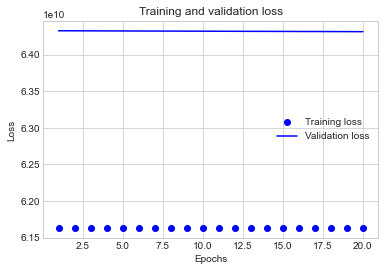

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [18]:
model.evaluate(X_test, y_test)

75/75 [==============================] - 0s 427us/step - loss: 62376763392.0000 - mae: 209578.7188


[62376763392.0, 209578.71875]